# Sparkify 项目 Workspace
这个 Workspace 包括一个迷你的子数据集（128MB），是完整数据集（12GB）的一个子集。在将你的项目部署到云上之前，你可以自由使用 Workspace 来创建你的项目或用Spark来探索这个较小数据集。设置 Spark 集群的指南可以在选修 Spark 课程的内容里找到。

你可以依照下面的步骤进行项目的数据分析和模型搭建部分。

In [1]:
# import pyspark related libraries
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min,\
    max, split, sum, sumDistinct,udf
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.functions
from pyspark.sql.types import IntegerType
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.types
from pyspark.sql import Window
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.Window
from pyspark.sql import SparkSession
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.SparkSession

from pyspark.ml import Pipeline
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#module-pyspark.ml
from pyspark.ml.classification import LogisticRegression, GBTClassifier, LinearSVC,\
    RandomForestClassifier
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#module-pyspark.ml.classification
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#module-pyspark.ml.evaluation
from pyspark.ml.feature import StandardScaler, VectorAssembler
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#module-pyspark.ml.feature
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#module-pyspark.ml.tuning

# import pandas, matplotlib, and seaborn for visualization and EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import datetime for parsing datetime object
import datetime
# https://docs.python.org/3/library/datetime.html
from time import time
# https://docs.python.org/3/library/time.html

In [2]:
# create a Spark session
spark = SparkSession.builder.getOrCreate()

# 加载和清洗数据
在这个 Workspace 中，小数据集的名称是 `mini_sparkify_event_data.json`.加载和清洗数据集，检查是否有无效或缺失数据——例如，没有userid或sessionid的数据。 

In [3]:
# load data(df)
df = spark.read.json('mini_sparkify_event_data.json')
# show the first row of df
df.head()
# https://blog.csdn.net/yisun123456/article/details/90677924

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [4]:
# show structure of df
df.printSchema()
# http://spark.apache.org/docs/latest/sql-getting-started.html

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# clean data & save the cleaned dataframe. 
## drop the rows in which userId or sessionId is null & save the omitted dataframe. 
df_clean = df.dropna(how = "any", subset = ["userId", "sessionId"])
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame

## drop the rows which are duplicated in userId & check the first 5 row of df_clean
df_clean.select("userId").dropDuplicates(["userId"]).sort("userId").show(5)
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
+------+
only showing top 5 rows



In [6]:
# drop empty user
df_clean = df_clean.filter(df["userId"] != "")
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame

# comparion with the original dataframe and the clean dataframe
df.count(), df_clean.count(), df.count() - df_clean.count()
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame
# delete 8346 records with null userId

(286500, 278154, 8346)

# 探索性数据分析
当你使用完整数据集时，通过加载小数据集，在 Spark 中完成基础操作来实现探索性数据分析。在这个 Workspace 中，我们已经提供给你一个你可以探索的小数据集。

### 定义客户流失

在你完成初步分析之后，创建一列 `Churn` 作为模型的标签。我建议你使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。作为一个奖励任务，你也可以深入了解 `Downgrade` 事件。


In [7]:
# show the distinct items in page column
df_clean.select("page").distinct().sort("page").show()
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [8]:
# create churn
# add churn_event column in df_clean
churn_label = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df_clean = df_clean.withColumn("churn_event", churn_label("page"))
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.udf
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=withcolumn#pyspark.sql.DataFrame.withColumn
# labelled churn event

# label user who churned according to churn event
window =  Window.partitionBy("userId")
# determine who has confirmed and recorde it in churn 
df_clean = df_clean.withColumn("churn", max("churn_event").over(window))
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=withcolumn#pyspark.sql.Window
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=over#pyspark.sql.Column.over

In [9]:
# check records on userId and churn columns
df_clean.select(["userId", "churn"]).dropDuplicates().show()

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
|   132|    0|
|   154|    0|
|   101|    1|
|    11|    0|
|   138|    0|
|300017|    0|
|100021|    1|
|    29|    1|
|    69|    0|
|   112|    0|
+------+-----+
only showing top 20 rows



In [10]:
# check the number of user
df_clean.select(["userId"]).dropDuplicates().count()

225

In [11]:
# add time column to df_clean
# convert timestamp into time string
convert = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %X"))
# https://www.jb51.net/article/130259.htm
# https://blog.csdn.net/p9bl5bxp/article/details/54945920

# convert ts/event_time
df_clean = df_clean.withColumn('event_time', convert("ts"))
# convet registration/add registration_time
df_clean = df_clean.withColumn("registration_time", convert("registration"))
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=withcolumn#pyspark.sql.DataFrame.withColumn
# added time columns when the event take place or registrates

In [12]:
# check data
df_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn_event: integer (nullable = true)
 |-- churn: integer (nullable = true)
 |-- event_time: string (nullable = true)
 |-- registration_time: string (nullable = true)



In [13]:
# check the first row
df_clean.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn_event=0, churn=0, event_time='2018-10-08 12:58:54', registration_time='2018-09-27 02:45:40')

### 探索数据
你定义好客户流失后，就可以执行一些探索性数据分析，观察留存用户和流失用户的行为。你可以首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。

In [14]:
# show in spark with the columns involved in churn
df_clean.select(['page', 'artist', 'song', 'level', 'userId', 'churn',\
                'event_time', 'registration_time']).show()

+-----------+--------------------+--------------------+-----+------+-----+-------------------+-------------------+
|       page|              artist|                song|level|userId|churn|         event_time|  registration_time|
+-----------+--------------------+--------------------+-----+------+-----+-------------------+-------------------+
|   NextSong|Sleeping With Sirens|Captain Tyin Knot...| free|100010|    0|2018-10-08 12:58:54|2018-09-27 02:45:40|
|   NextSong|Francesca Battist...|Beautiful_ Beauti...| free|100010|    0|2018-10-08 13:02:16|2018-09-27 02:45:40|
|   NextSong|              Brutha|          She's Gone| free|100010|    0|2018-10-08 13:05:32|2018-09-27 02:45:40|
|  Thumbs Up|                null|                null| free|100010|    0|2018-10-08 13:05:33|2018-09-27 02:45:40|
|   NextSong|         Josh Ritter|      Folk Bloodbath| free|100010|    0|2018-10-08 13:09:55|2018-09-27 02:45:40|
|   NextSong|               LMFAO|                 Yes| free|100010|    0|2018-1

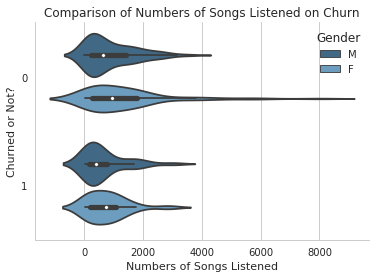

In [15]:
# visulization
# viz number of songs listened
# define counts of NextSong as number of songs listened
number = df_clean.filter('page == "NextSong"').\
                groupby(["userId","churn","gender","page"]).count().toPandas()
# number.head()
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=where#pyspark.sql.DataFrame.filter
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=groupby#pyspark.sql.DataFrame.groupby
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=count#pyspark.sql.DataFrame.count
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=topandas#pyspark.sql.DataFrame.toPandas
# user pandas dataframe can save a lot of time

number = number.pivot_table(index = ['userId', "churn", 'gender'],\
            columns = 'page', values = 'count').reset_index()
# number.head()
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html?highlight=pivot#pandas.DataFrame.pivot
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html?highlight=reset_index#pandas.DataFrame.reset_index

# Draw a combination of boxplot and kernel density estimate
sns.set(style="whitegrid")
ax = sns.violinplot(y = 'churn', x = 'NextSong', data = number,\
        hue = 'gender', split=False,  palette="Blues_d", orient = 'h')
# http://seaborn.pydata.org/generated/seaborn.violinplot.html#seaborn.violinplot
plt.ylabel('Churned or Not?')
plt.xlabel('Numbers of Songs Listened')
plt.legend(title = 'Gender')
plt.title('Comparison of Numbers of Songs Listened on Churn')
# https://www.jianshu.com/p/5ae17ace7984
sns.despine(ax = ax)
# http://seaborn.pydata.org/generated/seaborn.despine.html?highlight=despine#seaborn.despine
# Numbers of songs in regard to customers churned and not didn't vary a lot, except a litte bit outliers. 

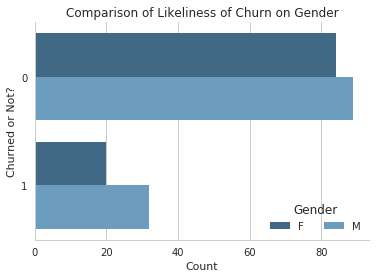

In [16]:
# viz churn on genders
# count user who churned or not on gender
gender_churn= df_clean.dropDuplicates(['userId','gender']).groupby(['churn',\
                'gender']).count().toPandas()
gender_churn.head()
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=groupby#pyspark.sql.DataFrame.groupby
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=count#pyspark.sql.DataFrame.count
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=topandas#pyspark.sql.DataFrame.toPandas

sns.set(style="whitegrid")
ax = sns.barplot(y = 'churn', x = 'count', hue = 'gender',\
                 data = gender_churn,  palette="Blues_d", orient = 'h')
# http://seaborn.pydata.org/generated/seaborn.barplot.html?highlight=barplot#seaborn.barplot
plt.ylabel("Churned or Not?")
plt.xlabel("Count")
plt.legend(title = 'Gender', ncol = 2)
plt.title("Comparison of Likeliness of Churn on Gender")
sns.despine(ax = ax)
# Male customers likely churn than female counterparts

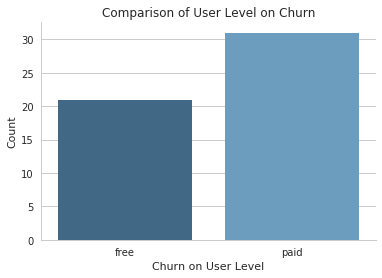

In [17]:
# viz churn on user types
# count churn on user level
level = df_clean.filter('page == "Cancellation Confirmation"').\
            groupby('level').count().toPandas()
# level.head()
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=where#pyspark.sql.DataFrame.filter
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=groupby#pyspark.sql.DataFrame.groupby
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=count#pyspark.sql.DataFrame.count
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=topandas#pyspark.sql.DataFrame.toPandas\

ax = sns.barplot(x = 'level', y = 'count', data = level,  palette="Blues_d")
plt.xlabel('Churn on User Level')
plt.ylabel('Count')
plt.title('Comparison of User Level on Churn')
sns.despine(ax = ax)
# Churn Usually Happens When a Customer Is Using a Paid Plan

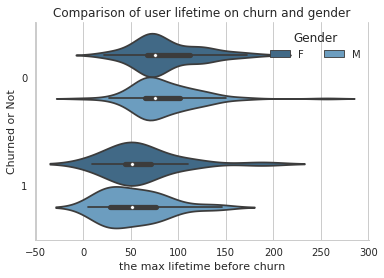

In [18]:
# viz churn on user lifetime
# create lifetime column for lifetime dataframe
lifetime = df_clean.select('userId', 'registration', 'ts', 'churn', 'gender')\
    .withColumn('lifetime', (df_clean.ts-df_clean.registration))
# lifetime.show()
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=withcolumn#pyspark.sql.DataFrame.withColumn

# calculate max lifetime of user
lifetime = lifetime.groupBy('userId', 'churn', 'gender').agg({'lifetime':'max'}).withColumnRenamed\
           ("max(lifetime)",'lifetime')
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=agg#pyspark.sql.DataFrame.agg
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=withcolumn#pyspark.sql.DataFrame.withColumnRenamed
# lifetime.show()

# convert timestramp into days and save lifetime as Pandas dataframe
lifetime = lifetime.select('userId', 'churn', 'gender', (col('lifetime')/1000/3600/24)\
           .alias('lifetime')).toPandas()


ax = sns.violinplot(y = 'churn', x = 'lifetime', hue = 'gender', data = lifetime, split = False,  palette="Blues_d", orient = 'h')
# http://seaborn.pydata.org/generated/seaborn.violinplot.html#seaborn.violinplot
plt.xlabel('the max lifetime before churn')
plt.ylabel('Churned or Not')
plt.title('Comparison of user lifetime on churn and gender')
plt.legend(title = 'Gender', ncol = 2, loc = 'best')
sns.despine(ax=ax)
# Churned Customer Use the Service for a Shorter Period of Time.

# 特征工程
熟悉了数据之后，就可以构建你认为会对训练模型帮助最大的特征。要处理完整数据集，你可以按照下述步骤：
- 写一个脚本来从小数据集中提取你需要的特征
- 确保你的脚本可以拓展到大数据集上，使用之前教过的最佳实践原则
- 在完整数据集上运行你的脚本，按运行情况调试代码

如果是在教室的 workspace，你可以直接用里面提供的小数据集来提取特征。确保当你开始使用 Spark 集群的时候，把上述的成果迁移到大数据集上。

In [19]:
# define user lifetime from registration timestamp to cancel timestamp
feature_1 = df_clean.select('userId', 'registration', 'ts').withColumn('lifetime',\
            (df_clean.ts-df_clean.registration))
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=withcolumn#pyspark.sql.DataFrame.withColumn

# aggregation with max lifetime as lifetime
feature_1 = feature_1.groupby('userId').agg({'lifetime':"max"})\
            .withColumnRenamed('max(lifetime)', 'life_time')
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=agg#pyspark.sql.DataFrame.agg
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=withcolumn#pyspark.sql.DataFrame.withColumnRenamed

# convert lifetime into days 
feature_1 = feature_1.select('userId', (col('life_time')\
    /1000/3600/24).alias('life_time'))

# summary of feature_1
feature_1.describe(['life_time']).show()
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=describe#pyspark.sql.DataFrame.describe

+-------+-------------------+
|summary|          life_time|
+-------+-------------------+
|  count|                225|
|   mean|   79.8456834876543|
| stddev|  37.66147001861254|
|    min|0.31372685185185184|
|    max|  256.3776736111111|
+-------+-------------------+



In [20]:
# Total Songs by Users
# count songs by users 
feature_2 = df_clean.select('userId', 'song').groupby('userId').count()\
    .withColumnRenamed('count', 'num_songs')
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=groupby#pyspark.sql.DataFrame.groupby
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=count#pyspark.sql.DataFrame.count
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=withcolumn#pyspark.sql.DataFrame.withColumnRenamed

# summary of total_songs
feature_2.describe(['num_songs']).show()
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=describe#pyspark.sql.DataFrame.describe

+-------+-----------------+
|summary|        num_songs|
+-------+-----------------+
|  count|              225|
|   mean|          1236.24|
| stddev|1329.531716432519|
|    min|                6|
|    max|             9632|
+-------+-----------------+



In [21]:
# Number of Thumbs Up
# filter thumbs up in page column and count number by user
feature_3 = df_clean.select("userId", 'page').filter(df_clean.page == 'Thumbs Up')\
            .groupby("userId").count().withColumnRenamed('count', 'num_thumb_up')
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=where#pyspark.sql.DataFrame.filter
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=groupby#pyspark.sql.DataFrame.groupby
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=count#pyspark.sql.DataFrame.count
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=withcolumn#pyspark.sql.DataFrame.withColumnRenamed

# summary of number of thumbs up
feature_3.describe(['num_thumb_up']).show()
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=describe#pyspark.sql.DataFrame.describe

# Number of Thumbs Down
# filter thumbs down in page column and count number by user
feature_4 = df_clean.select('userId', 'page').where(df_clean.page == "Thumbs Down")\
      .groupby('userId').count().withColumnRenamed('count','num_thumb_down')
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=describe#pyspark.sql.DataFrame.where
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=groupby#pyspark.sql.DataFrame.groupby
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=count#pyspark.sql.DataFrame.count
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=withcolumn#pyspark.sql.DataFrame.withColumnRenamed

# summary of number of thumbs down
feature_4.describe(['num_thumb_down']).show()
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=describe#pyspark.sql.DataFrame.describe

+-------+-----------------+
|summary|     num_thumb_up|
+-------+-----------------+
|  count|              220|
|   mean|            57.05|
| stddev|65.67028650524044|
|    min|                1|
|    max|              437|
+-------+-----------------+

+-------+------------------+
|summary|    num_thumb_down|
+-------+------------------+
|  count|               203|
|   mean|12.541871921182265|
| stddev|13.198108566983787|
|    min|                 1|
|    max|                75|
+-------+------------------+



In [22]:
# number of songs added to playlist
# count number of Add to Playlist in page by user
feature_5 = df_clean.select('userId', 'page').where(df_clean.page == 'Add to Playlist')\
            .groupby('userId').count().withColumnRenamed('count', 'add_to_playlist')
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=describe#pyspark.sql.DataFrame.where
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=groupby#pyspark.sql.DataFrame.groupby
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=count#pyspark.sql.DataFrame.count
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=withcolumn#pyspark.sql.DataFrame.withColumnRenamed

# summary of Add to Playlist
feature_5.describe(['add_to_playlist']).show()
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=describe#pyspark.sql.DataFrame.describe

+-------+-----------------+
|summary|  add_to_playlist|
+-------+-----------------+
|  count|              215|
|   mean|30.35348837209302|
| stddev| 32.8520568555997|
|    min|                1|
|    max|              240|
+-------+-----------------+



In [23]:
# number of friends added
# count number add friend by users
feature_6 = df_clean.select('userId', 'page').where(df_clean.page == 'Add Friend') \
            .groupby("userId").count().withColumnRenamed('count', 'add_friend')
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=describe#pyspark.sql.DataFrame.where
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=groupby#pyspark.sql.DataFrame.groupby
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=count#pyspark.sql.DataFrame.count
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=withcolumn#pyspark.sql.DataFrame.withColumnRenamed

# summary of add friend
feature_6.describe(['add_friend']).show()
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=describe#pyspark.sql.DataFrame.describe

+-------+------------------+
|summary|        add_friend|
+-------+------------------+
|  count|               206|
|   mean|20.762135922330096|
| stddev|20.646779074405007|
|    min|                 1|
|    max|               143|
+-------+------------------+



In [24]:
# length of listening by user
feature_7 = df_clean.select('userId', "length")\
            .groupby('userId').sum()\
            .withColumnRenamed('sum(length)', 'total_listen')
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=groupby#pyspark.sql.DataFrame.groupby
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=describe#pyspark.sql.functions.sum
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=withcolumn#pyspark.sql.DataFrame.withColumnRenamed

# summary of listen time
feature_7.describe(['total_listen']).show()
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=describe#pyspark.sql.DataFrame.describe

+-------+------------------+
|summary|      total_listen|
+-------+------------------+
|  count|               225|
|   mean|252558.32065155543|
| stddev| 275396.4038847635|
|    min|         691.66884|
|    max|1991154.9155799907|
+-------+------------------+



In [25]:
# number of songs listened per session by users
# count songs listened by userId and sessionId
feature_8 = df_clean.where('page == "NextSong"').groupBy('userId', 'sessionId').count()
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=describe#pyspark.sql.DataFrame.where
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=groupby#pyspark.sql.DataFrame.groupby
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=count#pyspark.sql.DataFrame.count
#feature_8.show()

# calculated average numbers of listened per session by users
feature_8 = feature_8.groupby(['userId']).agg({'count':'avg'})\
            .withColumnRenamed('avg(count)', 'avg_songs_played')
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=agg#pyspark.sql.GroupedData.agg
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=withcolumn#pyspark.sql.DataFrame.withColumnRenamed

# summary of average songs played per session by users
feature_8.describe(['avg_songs_played']).show()
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=describe#pyspark.sql.DataFrame.describe

+-------+-----------------+
|summary| avg_songs_played|
+-------+-----------------+
|  count|              225|
|   mean|70.78971233958933|
| stddev| 42.6153697543817|
|    min|              3.0|
|    max|286.6666666666667|
+-------+-----------------+



In [26]:
# Gender
# drop duplicated records by userId and gender
# replace gender into int 
feature_9 = df_clean.select('userId', 'gender').dropDuplicates()\
            .replace(['M', 'F'], ['0', '1'], 'gender')
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=dropduplicates#pyspark.sql.DataFrame.dropDuplicates
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=replace#pyspark.sql.DataFrame.replace

# cast gender into int
feature_9 = feature_9.select('userId', col('gender').cast('int'))
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=cast#pyspark.sql.Column.cast

# summary of gender
feature_9.describe(['gender']).show()
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=describe#pyspark.sql.DataFrame.describe

+-------+-------------------+
|summary|             gender|
+-------+-------------------+
|  count|                225|
|   mean| 0.4622222222222222|
| stddev|0.49968243883744773|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



In [27]:
# nubmer of artists listened
# filter song listened by userId and artist
# drop duplicates records
feature_10 = df_clean.filter(df_clean.page == 'NextSong')\
            .select('userId', 'artist').dropDuplicates()
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=where#pyspark.sql.DataFrame.filter
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=dropduplicates#pyspark.sql.DataFrame.dropDuplicates
#feature_10.show()

# count artist by users
feature_10 = feature_10.groupby('userId').count()\
            .withColumnRenamed('count', 'num_artist')
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=groupby#pyspark.sql.DataFrame.groupby
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=count#pyspark.sql.DataFrame.count
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=withcolumn#pyspark.sql.DataFrame.withColumnRenamed

# summary of num_artist
feature_10.describe(['num_artist']).show()
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=describe#pyspark.sql.DataFrame.describe

+-------+-----------------+
|summary|       num_artist|
+-------+-----------------+
|  count|              225|
|   mean|696.3777777777777|
| stddev|603.9518698630802|
|    min|                3|
|    max|             3544|
+-------+-----------------+



In [28]:
# churn label
# alias churn as label 
# drop duplicated records
label = df_clean.select('userId', col('churn').alias('label'))\
        .dropDuplicates()
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=alias#pyspark.sql.Column.alias

# summary of label
label.describe().show()
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=describe#pyspark.sql.DataFrame.describe

+-------+------------------+------------------+
|summary|            userId|             label|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|0.2311111111111111|
| stddev|105396.47791907164|0.4224832108996327|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



In [29]:
# merge all features into one dataset
# join all features in outer 
# drop userId
#  fill null in empty cells
data = feature_1.join(feature_2, 'userId', 'outer')\
    .join(feature_3, 'userId', 'outer' )\
    .join(feature_4, 'userId', 'outer' )\
    .join(feature_5, 'userId', 'outer' )\
    .join(feature_6, 'userId', 'outer' )\
    .join(feature_7, 'userId', 'outer' )\
    .join(feature_8, 'userId', 'outer' )\
    .join(feature_9, 'userId', 'outer' )\
    .join(feature_10, 'userId', 'outer' )\
    .join(label, 'userId', 'outer' )\
    .drop('userId')\
    .fillna(0)
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=join#pyspark.sql.DataFrame.join
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=drop#pyspark.sql.DataFrame.drop
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=fillna#pyspark.sql.DataFrame.fillna

# summary of data
data.describe().show()
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=describe#pyspark.sql.DataFrame.describe

+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+
|summary|          life_time|        num_songs|      num_thumb_up|    num_thumb_down|   add_to_playlist|        add_friend|      total_listen| avg_songs_played|            gender|       num_artist|             label|
+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+
|  count|                225|              225|               225|               225|               225|               225|               225|              225|               225|              225|               225|
|   mean|  79.84568348765428|          1236.24|55.782222222222224|11.315555555555555|29.004444444444445| 19.00888888888889|252558.32

# 建模
将完整数据集分成训练集、测试集和验证集。测试几种你学过的机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，我建议选用 F1 score 作为优化指标。

In [30]:
# explore structure of data 
data.printSchema()

root
 |-- life_time: double (nullable = false)
 |-- num_songs: long (nullable = true)
 |-- num_thumb_up: long (nullable = true)
 |-- num_thumb_down: long (nullable = true)
 |-- add_to_playlist: long (nullable = true)
 |-- add_friend: long (nullable = true)
 |-- total_listen: double (nullable = false)
 |-- avg_songs_played: double (nullable = false)
 |-- gender: integer (nullable = true)
 |-- num_artist: long (nullable = true)
 |-- label: integer (nullable = true)



In [31]:
# Vectorize and Standardize data to fit and transform models
# vector assembler
cols = ['life_time', 'num_songs', 'num_thumb_up', \
       'num_thumb_down', 'add_to_playlist','add_friend', 'total_listen',\
       'avg_songs_played', 'gender', 'num_artist']

# merges multiple columns into a vector column.
vecAssembler = VectorAssembler(inputCols = cols, outputCol = 'NumFeatures')
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=vectorassembler#pyspark.ml.feature.VectorAssembler
data = vecAssembler.transform(data)
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=transform#pyspark.ml.feature.VectorAssembler.transform

# show data
data.show()

+------------------+---------+------------+--------------+---------------+----------+------------------+------------------+------+----------+-----+--------------------+
|         life_time|num_songs|num_thumb_up|num_thumb_down|add_to_playlist|add_friend|      total_listen|  avg_songs_played|gender|num_artist|label|         NumFeatures|
+------------------+---------+------------+--------------+---------------+----------+------------------+------------------+------+----------+-----+--------------------+
|  55.6436574074074|      381|          17|             5|              7|         4| 66940.89735000003|39.285714285714285|     1|       252|    0|[55.6436574074074...|
| 70.07462962962963|      474|          21|             6|              8|         4| 94008.87593999993|              64.5|     0|       339|    0|[70.0746296296296...|
| 71.31688657407408|       11|           0|             0|              0|         0|2089.1131000000005|               8.0|     0|         8|    1|(10,[0,1

In [32]:
# standard scaler
# Standardizes features by removing the mean and scaling to unit variance using column summary statistics on the samples in the training set
standardScaler = StandardScaler(inputCol = 'NumFeatures', outputCol = 'features', withStd = True)
model = standardScaler.fit(data)
data = model.transform(data)
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=standardscaler#pyspark.ml.feature.StandardScaler
data.show()
# vecotrized and standardized data

+------------------+---------+------------+--------------+---------------+----------+------------------+------------------+------+----------+-----+--------------------+--------------------+
|         life_time|num_songs|num_thumb_up|num_thumb_down|add_to_playlist|add_friend|      total_listen|  avg_songs_played|gender|num_artist|label|         NumFeatures|            features|
+------------------+---------+------------+--------------+---------------+----------+------------------+------------------+------+----------+-----+--------------------+--------------------+
|  55.6436574074074|      381|          17|             5|              7|         4| 66940.89735000003|39.285714285714285|     1|       252|    0|[55.6436574074074...|[1.47746907860760...|
| 70.07462962962963|      474|          21|             6|              8|         4| 94008.87593999993|              64.5|     0|       339|    0|[70.0746296296296...|[1.86064509948757...|
| 71.31688657407408|       11|           0|       

In [33]:
# data split
# divid data into 6:2:2 
train, validation, test = data.randomSplit([0.6, 0.2, 0.2], seed = 42)
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=randomsplit#pyspark.sql.DataFrame.randomSplit
# divid train, validation, test 6:2:2.

In [34]:
# model design
# set baseline model to grip the baseline of metric values for futher models
'''
    Evaluate two baseline models, one with all users labelled as churn = 1, and the others labelled as churn = 0. 
    And calculate accuracy and f1 score.
    To konw the baseline values of metrics of futher models.
'''

# baseline model for churn = 1
result_baseline_1 = test.withColumn('prediction', lit(1.0))
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=withcolumn#pyspark.sql.DataFrame.withColumn
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=lit#pyspark.sql.functions.lit

evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction')
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=multiclassclassificationevaluator#pyspark.ml.evaluation.MulticlassClassificationEvaluator

print("Test Set 1 Metrics: ")
print('Accuracy: {}'.format(evaluator.evaluate(result_baseline_1, {evaluator.metricName: 'accuracy'})))
print('F1: {}'.format(evaluator.evaluate(result_baseline_1, {evaluator.metricName: 'f1'})))


# baseline model for churn = 0 
result_baseline_0 = test.withColumn('prediction', lit(0.0))
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=withcolumn#pyspark.sql.DataFrame.withColumn
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=lit#pyspark.sql.functions.lit
evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction')
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=multiclassclassificationevaluator#pyspark.ml.evaluation.MulticlassClassificationEvaluator

print("Test Set 0 Metrics: ")
print('Accuracy: {}'.format(evaluator.evaluate(result_baseline_0, {evaluator.metricName: 'accuracy'})))
print('F1: {}'.format(evaluator.evaluate(result_baseline_0, {evaluator.metricName: 'f1'})))

Test Set 1 Metrics: 
Accuracy: 0.29411764705882354
F1: 0.1336898395721925
Test Set 0 Metrics: 
Accuracy: 0.7058823529411765
F1: 0.5841784989858012


In [37]:
# Choose the best model from Logisitic Regression, Gradient-Boosted Trees, Support Vector Machine, and Random Forest by check accurary and f1 score stemmed from the training and validating the dataset 
# Logistic Regression
# Initialize Classifier with 10 iterations
lr = LogisticRegression(maxIter = 10)
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=logisticregression#pyspark.ml.classification.LogisticRegression

# Set f1 score as evaluator
evaluator = MulticlassClassificationEvaluator(metricName = 'f1')
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=multiclassclassificationevaluator#pyspark.ml.evaluation.MulticlassClassificationEvaluator

# builder for a param grid used in grid search-based model selection.
grid  = ParamGridBuilder().build()
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=paramgrid#pyspark.ml.tuning.ParamGridBuilder

# 3-fold cross validation performs LogisticRegression 
cv_lr = CrossValidator(estimator = lr, estimatorParamMaps = grid,\
                       evaluator = evaluator, numFolds = 3)
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=crossvalidator#pyspark.ml.tuning.CrossValidator

# start time
start = time()
# fit trainset
model_lr = cv_lr.fit(train)
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=fit#pyspark.ml.classification.LogisticRegression.fit
# end time
end = time()

model_lr.avgMetrics
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=avgmetric#pyspark.ml.tuning.CrossValidatorModel.avgMetrics

# print the time span of the process
print('The training process took {} seconds'.format(end - start))

The training process took 524.7114186286926 seconds


In [38]:
# transform validationset
result_lr = model_lr.transform(validation)
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=transform#pyspark.ml.classification.LogisticRegressionModel.transform

# set evaluator for prediction
evaluator = MulticlassClassificationEvaluator(predictionCol ='prediction')
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=multiclassclassificationevaluator#pyspark.ml.evaluation.MulticlassClassificationEvaluator

# Print Accuacy and F1 score of Logistic Regression
print('Logistic Regression Metrics: ')
print('Accuracy: {}'.format(evaluator.evaluate(result_lr, {evaluator.metricName: 'accuracy'})))
print('F1: {}'.format(evaluator.evaluate(result_lr, {evaluator.metricName: 'f1'})))
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=evaluate#pyspark.ml.evaluation.MulticlassClassificationEvaluator.evaluate

Logistic Regression Metrics: 
Accuracy: 0.7959183673469388
F1: 0.7871315192743764


In [39]:
# Gradient-Boosted Trees
# Initialize Classifier with 10 iterations and 42 samples
gbt = GBTClassifier(maxIter = 10, seed = 42)
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=gbtclassifier#pyspark.ml.classification.GBTClassifier

# Set Evaluator
evaluator = MulticlassClassificationEvaluator(metricName = 'f1')
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=multiclassclassificationevaluator#pyspark.ml.evaluation.MulticlassClassificationEvaluator

# build paramGrid
grid = ParamGridBuilder().build()
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=paramgrid#pyspark.ml.tuning.ParamGridBuilder

# 3-fold cross valiation with paramgrid
cv_gbt = CrossValidator(estimator = gbt,\
                            evaluator = evaluator,\
                            estimatorParamMaps = grid,\
                            numFolds = 3)
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=crossvalidator#pyspark.ml.tuning.CrossValidator

In [40]:
# Set start time
start = time()
# fit trainset
model_gbt = cv_gbt.fit(train)
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=fit#pyspark.ml.classification.LogisticRegression.fit
# end time
end = time()

model_gbt.avgMetrics
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=avgmetric#pyspark.ml.tuning.CrossValidatorModel.avgMetrics

# print the time span of the process
print('The training process took {} seconds'.format(end - start))


The training process took 1088.8902523517609 seconds


In [41]:
# transform validation set
result_gbt = model_gbt.transform(validation)
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=transform#pyspark.ml.classification.LogisticRegressionModel.transform

# set evaluator for prediction
evaluator = MulticlassClassificationEvaluator(predictionCol ='prediction')
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=multiclassclassificationevaluator#pyspark.ml.evaluation.MulticlassClassificationEvaluator

# print accurcay & f1 score of GBT
print('Gradient Boosted Trees Metrics: ')
print('Accuracy: {}'.format(evaluator.evaluate(result_gbt, {evaluator.metricName: 'accuracy'})))
print('F1: {}'.format(evaluator.evaluate(result_gbt, {evaluator.metricName: 'f1'})))
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=evaluate#pyspark.ml.evaluation.MulticlassClassificationEvaluator.evaluate

Gradient Boosted Trees Metrics: 
Accuracy: 0.7142857142857143
F1: 0.7142857142857142


In [35]:
# Support Vector Machine
## Initialize Classifier with 10 iterations
svm = LinearSVC(maxIter = 10)
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=linearsvc#pyspark.ml.classification.LinearSVC

# Set Evaluator
evaluator = MulticlassClassificationEvaluator(metricName = 'f1')
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=multiclassclassificationevaluator#pyspark.ml.evaluation.MulticlassClassificationEvaluator

# build paramGrid
grid = ParamGridBuilder().build()
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=paramgrid#pyspark.ml.tuning.ParamGridBuilder

# 3-fold cross valiation with paramgrid
cv_svm = CrossValidator(estimator = svm,\
                            evaluator = evaluator,\
                            estimatorParamMaps = grid,\
                            numFolds = 3)
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=crossvalidator#pyspark.ml.tuning.CrossValidator

# get start time
start = time()
# fit trainset
model_svm = cv_svm.fit(train)
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=fit#pyspark.ml.classification.LogisticRegression.fit
# end time
end = time()

model_svm.avgMetrics
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=avgmetric#pyspark.ml.tuning.CrossValidatorModel.avgMetrics

# Print the time span of the process 
print('The training process took {} seconds'.format(end - start))

# transform validation set
result_svm = model_svm.transform(validation)
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=transform#pyspark.ml.classification.LogisticRegressionModel.transform

# set evaluator for prediction
evaluator = MulticlassClassificationEvaluator(predictionCol ='prediction')
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=multiclassclassificationevaluator#pyspark.ml.evaluation.MulticlassClassificationEvaluator

# print accuracy and f1 score of SVM
print('Support Vector Machine Metrics: ')
print('Accuracy: {}'.format(evaluator.evaluate(result_svm, {evaluator.metricName: 'accuracy'})))
print('F1: {}'.format(evaluator.evaluate(result_svm, {evaluator.metricName: 'f1'})))
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=evaluate#pyspark.ml.evaluation.MulticlassClassificationEvaluator.evaluate

The training process took 741.0048565864563 seconds
Support Vector Machine Metrics: 
Accuracy: 0.7959183673469388
F1: 0.7054730983302412


In [66]:
# Random Forest
# Initialize Classifier
rf = RandomForestClassifier()
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=randomforest#pyspark.ml.classification.RandomForestClassifier

# Set Evaluator
evaluator = MulticlassClassificationEvaluator(metricName = 'f1')
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=multiclassclassificationevaluator#pyspark.ml.evaluation.MulticlassClassificationEvaluator

# build paramGrid
grid = ParamGridBuilder().build()
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=paramgrid#pyspark.ml.tuning.ParamGridBuilder

# 3-fold cross validation
cv_rf = CrossValidator(estimator = rf,\
                            evaluator = evaluator,\
                            estimatorParamMaps = grid,\
                            numFolds = 3)
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=crossvalidator#pyspark.ml.tuning.CrossValidator

# set start time
start = time()
# fit train set
model_rf = cv_rf.fit(train)
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=fit#pyspark.ml.classification.LogisticRegression.fit
# end time
end = time()
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=avgmetric#pyspark.ml.tuning.CrossValidatorModel.avgMetrics

model_rf.avgMetrics
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=avgmetric#pyspark.ml.tuning.CrossValidatorModel.avgMetrics

# print the time span of the process
print('The training process took {} seconds'.format(end - start))

# transform validation set
result_rf = model_rf.transform(validation)
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=transform#pyspark.ml.classification.LogisticRegressionModel.transform

# set evaluator for prediction
evaluator = MulticlassClassificationEvaluator(predictionCol ='prediction')
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=multiclassclassificationevaluator#pyspark.ml.evaluation.MulticlassClassificationEvaluator

# print accuracy and f1 score of RF
print('Random Forest Metrics: ')
print('Accuracy: {}'.format(evaluator.evaluate(result_rf, {evaluator.metricName: 'accuracy'})))
print('F1: {}'.format(evaluator.evaluate(result_rf, {evaluator.metricName: 'f1'})))
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=evaluate#pyspark.ml.evaluation.MulticlassClassificationEvaluator.evaluate

The training process took 587.9695703983307 seconds
Random Forest Metrics: 
Accuracy: 0.7959183673469388
F1: 0.7871315192743764


### 模型选择
- 逻辑回归模型的准确率为: 0.7959 & F1 score: 0.7871, using 524.71 seconds.
- 梯度提升树模型的准确率为: 0.7143 & F1 score:  0.7143, using 1088.89 seconds.
- 支持向量机模型的准确率为: 0.7959 & F1 score: 0.7055, using 741.00 seconds.
- 随机森林模型的准确率为: 0.7959 & F1 score: 0.7871, using 587.97 seconds.

通过比较上述结构，以目前小数据量的数据集上的表现上来看，逻辑回归和随机森林同时达到了最高的准确率和F1值，并且耗时几乎差不多。梯度提升树模型的准确率和F1值一致，并高于支持向量机的F1值，但时间开销是目前四个模型中最大的，几乎为随机森林的一倍。考虑到12G的全数据下，逻辑回归将显出更大的欠拟合，和支持向量机一样会大幅度增加时间开销。梯度提升树和随机森林被选择为进一步调优的模型，同时其算法所带的功能可直接反应出各特征对于分类的重要性，这将对进一步优化特征选择起到极大的作用。



In [37]:
# Hyperparams Tunning GBT
# initalize GBT classifier 
gbt = GBTClassifier()

# build paramGrid in 5-10 maxDepth and 10-15 maxIter
paramGrid_gbt = ParamGridBuilder()\
    .addGrid(gbt.maxDepth, [5,10])\
    .addGrid(gbt.maxIter, [10,15])\
    .build()
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=paramgrid#pyspark.ml.tuning.ParamGridBuilder

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName = 'f1')
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=multiclassclassificationevaluator#pyspark.ml.evaluation.MulticlassClassificationEvaluator

# 3-fold cross validation
crossval_gbt = CrossValidator(estimator = gbt, \
                             estimatorParamMaps = paramGrid_gbt,\
                             evaluator = f1_evaluator,\
                             numFolds = 3)
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=crossvalidator#pyspark.ml.tuning.CrossValidator

In [38]:
# fit train set
cvModel_gbt = crossval_gbt.fit(train)
# get the best f1 score
cvModel_gbt.avgMetrics
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=avgmetric#pyspark.ml.tuning.CrossValidatorModel.avgMetrics
# the best f1 scores are higher than the prelimiary test

[0.7383246458917002, 0.7383246458917002, 0.738070131756161, 0.738070131756161]

In [41]:
# get the corresponding maxDepth and maxIter of the best f1 score
cvModel_gbt.getEstimatorParamMaps()
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=getestimatorparammaps#pyspark.ml.tuning.CrossValidator.getEstimatorParamMaps

[{Param(parent='GBTClassifier_b5f02be7b37c', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5,
  Param(parent='GBTClassifier_b5f02be7b37c', name='maxIter', doc='max number of iterations (>= 0).'): 10},
 {Param(parent='GBTClassifier_b5f02be7b37c', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5,
  Param(parent='GBTClassifier_b5f02be7b37c', name='maxIter', doc='max number of iterations (>= 0).'): 15},
 {Param(parent='GBTClassifier_b5f02be7b37c', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10,
  Param(parent='GBTClassifier_b5f02be7b37c', name='maxIter', doc='max number of iterations (>= 0).'): 10},
 {Param(parent='GBTClassifier_b5f02be7b37c', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means

In [43]:
# best GBT model with maxDepth 5 and maxIter 10
gbt_best = GBTClassifier( maxDepth = 5, maxIter = 10, seed =42)
# fit train set
gbt_best_model = gbt_best.fit(train)
# transform test set 
results_final = gbt_best_model.transform(test)

In [44]:
# final resuls metrics from GBT
evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction')
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=multiclassclassificationevaluator#pyspark.ml.evaluation.MulticlassClassificationEvaluator

# Print accuracy and f1 score
print("Test Set Metrics: ")
print('Accuracy: {}'.format(evaluator.evaluate(results_final, {evaluator.metricName: 'accuracy'})))
print('F-1 Score: {}'.format(evaluator.evaluate(results_final, {evaluator.metricName: 'f1'})))
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=evaluate#pyspark.ml.evaluation.MulticlassClassificationEvaluator.evaluate

Test Set Metrics: 
Accuracy: 0.7941176470588235
F-1 Score: 0.7820069204152248


Text(0.5,1,'GBT Feature Importances')

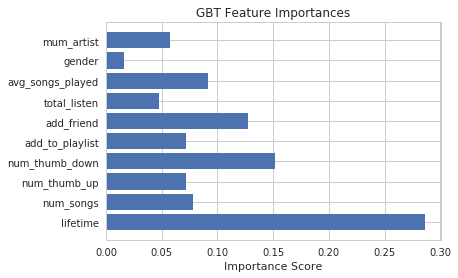

In [45]:
# features importance from GBT model
feat_imp_GBT = gbt_best_model.featureImportances.values
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=featureimportances#pyspark.ml.classification.GBTClassificationModel.featureImportances

# set y axis
cols = ['lifetime', 'num_songs', 'num_thumb_up', \
        'num_thumb_down', 'add_to_playlist','add_friend', 'total_listen',\
       'avg_songs_played', 'gender', 'mum_artist']
y_pos = np.arange(len(cols))

# draw horizontal barplot to show feature importances
plt.barh(y_pos, feat_imp_GBT, align = 'center')
plt.yticks(y_pos, cols)
plt.xlabel("Importance Score")
plt.title("GBT Feature Importances")
# https://matplotlib.org/api/_as_gen/matplotlib.pyplot.barh.html?highlight=barh#matplotlib.pyplot.barh

In [46]:
# Hyperparams Tuing Random Forest
rf = RandomForestClassifier()
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=randomforest#pyspark.ml.classification.RandomForestClassifier

# Set Evaluator
evaluator = MulticlassClassificationEvaluator(metricName = 'f1')
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=multiclassclassificationevaluator#pyspark.ml.evaluation.MulticlassClassificationEvaluator

# build paramGrid with 5-50 maxDepth and 10-100 numTrees
paramGrid_rf = ParamGridBuilder().addGrid(rf.maxDepth, [5,50])\
                .addGrid(rf.numTrees, [10,100]).build()
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=paramgrid#pyspark.ml.tuning.ParamGridBuilder

# 3-fold cross validation
cv_rf = CrossValidator(estimator = rf,\
                            evaluator = evaluator,\
                            estimatorParamMaps = grid,\
                            numFolds = 3)
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=crossvalidator#pyspark.ml.tuning.CrossValidator

In [48]:
# fit train set
cvModel_rf = cv_rf.fit(train)
# get the best f1 
cvModel_rf.avgMetrics
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=avgmetric#pyspark.ml.tuning.CrossValidatorModel.avgMetrics
# the best f1 score is lower than the score obtained in the preliminary test

[0.741186854250764]

In [63]:
# extract Param Map of the best f1
cvModel_rf.extractParamMap()
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=extractparammap#pyspark.ml.classification.RandomForestClassifier.extractParamMap
# estimatorParamMaps is [{}]

{Param(parent='CrossValidatorModel_3645a9d055ab', name='seed', doc='random seed.'): -8408287757015260476,
 Param(parent='CrossValidatorModel_3645a9d055ab', name='estimator', doc='estimator to be cross-validated'): RandomForestClassifier_1ff1a04f9e25,
 Param(parent='CrossValidatorModel_3645a9d055ab', name='estimatorParamMaps', doc='estimator param maps'): [{}],
 Param(parent='CrossValidatorModel_3645a9d055ab', name='evaluator', doc='evaluator used to select hyper-parameters that maximize the validator metric'): MulticlassClassificationEvaluator_6b03453895b5}

In [64]:
# best RF model as the default model
rf_best = RandomForestClassifier()
# fit train set
rf_best_model = rf_best.fit(train)
# transfomr test set
results_final_rf = rf_best_model.transform(test)

In [67]:
# final resuls metrics from RF
# set evaluator 
evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction')
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=multiclassclassificationevaluator#pyspark.ml.evaluation.MulticlassClassificationEvaluator

# Print accuracy and f1 score
print("Test Set Metrics: ")
print('Accuracy: {}'.format(evaluator.evaluate(results_final_rf, {evaluator.metricName: 'accuracy'})))
print('F-1 Score: {}'.format(evaluator.evaluate(results_final_rf, {evaluator.metricName: 'f1'})))
# # http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=evaluate#pyspark.ml.evaluation.MulticlassClassificationEvaluator.evaluate

Test Set Metrics: 
Accuracy: 0.8235294117647058
F-1 Score: 0.7955182072829133


Text(0.5,1,'RF Feature Importances')

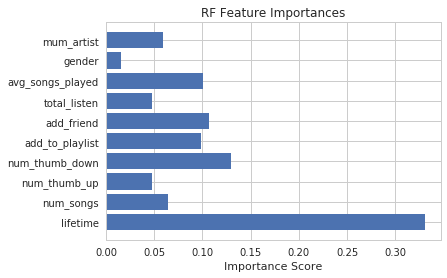

In [65]:
# features importance from RF model
# get feature importances
feat_imp_rf= rf_best_model.featureImportances.values
# http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=featureimportances#pyspark.ml.classification.GBTClassificationModel.featureImportances

# set y axis
cols = ['lifetime', 'num_songs', 'num_thumb_up', \
        'num_thumb_down', 'add_to_playlist','add_friend', 'total_listen',\
       'avg_songs_played', 'gender', 'mum_artist']
y_pos = np.arange(len(cols))

# draw horizontal barplot
plt.barh(y_pos, feat_imp_rf, align = 'center')
plt.yticks(y_pos, cols)
plt.xlabel("Importance Score")
plt.title("RF Feature Importances")
# https://matplotlib.org/api/_as_gen/matplotlib.pyplot.barh.html?highlight=barh#matplotlib.pyplot.barh

# 结论
- 由梯度提升树和随机森林模型调优后所得准确率和f1值对比可知，随机森林的结果略优于梯度提升树。
- 从特征重要性对比可知，两种模型所要求对于分类的特征重要性基本一致，lefttime即用户的使用时间对于是否churn及其重要，num_thumb_down,add_friends, avg_songs_played,及num_artist。


In [73]:
# final resuls metrics
evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction')
print("Test Set Metrics in GBT: ")
print('Accuracy: {}'.format(evaluator.evaluate(results_final, {evaluator.metricName: 'accuracy'})))
print('F-1 Score: {}'.format(evaluator.evaluate(results_final, {evaluator.metricName: 'f1'})))
print('-----------------------------------------')

print("Test Set Metrics in RF: ")
print('Accuracy: {}'.format(evaluator.evaluate(results_final_rf, {evaluator.metricName: 'accuracy'})))
print('F-1 Score: {}'.format(evaluator.evaluate(results_final_rf, {evaluator.metricName: 'f1'})))

Test Set Metrics in GBT: 
Accuracy: 0.7941176470588235
F-1 Score: 0.7820069204152248
-----------------------------------------
Test Set Metrics in RF: 
Accuracy: 0.8235294117647058
F-1 Score: 0.7955182072829133


Text(0.5,1,'GBT Feature Importances')

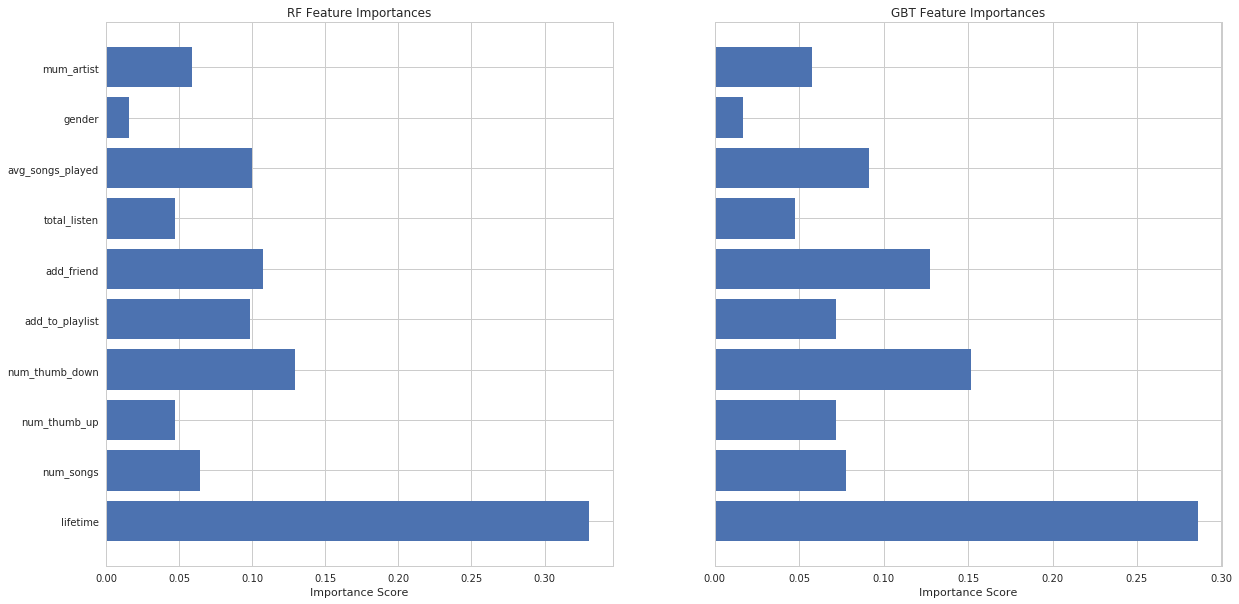

In [74]:
# draw the comprison of feature importances between two models
# set y axis
cols = ['lifetime', 'num_songs', 'num_thumb_up', \
        'num_thumb_down', 'add_to_playlist','add_friend', 'total_listen',\
       'avg_songs_played', 'gender', 'mum_artist']
y_pos = np.arange(len(cols))
# set figure size 20*10
plt.figure(figsize = (20, 10))

# left subplot
plt.subplot(1,2,1)
plt.barh(y_pos, feat_imp_rf, align = 'center')
plt.yticks(y_pos, cols)
plt.xlabel("Importance Score")
plt.title("RF Feature Importances")

# right subplot
plt.subplot(1,2,2)
plt.yticks(y_pos, '')
plt.barh(y_pos, feat_imp, align = 'center')
plt.xlabel("Importance Score")
plt.title("GBT Feature Importances")
# https://matplotlib.org/api/_as_gen/matplotlib.figure.Figure.html?highlight=figure%20figsize
# https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html?highlight=subplot#matplotlib.pyplot.subplot
# https://matplotlib.org/api/_as_gen/matplotlib.pyplot.barh.html?highlight=barh#matplotlib.pyplot.barh

# 最后一步
清理你的代码，添加注释和重命名变量，使得代码更易读和易于维护。参考 Spark 项目概述页面和数据科学家毕业项目审阅要求，确保你的项目包含了毕业项目要求的所有内容，并且满足所有审阅要求。记得在 GitHub 代码库里包含一份全面的文档——README文件，以及一个网络应用程序或博客文章。